**Import Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from scipy.special import softmax

import matplotlib.pyplot as plt

**Load and Preprocess Data**

In [2]:
def load_images_from_csv(data_dir, csv_path, image_size=(50, 50), limit=None):
    """
    data_dir:    Directory containing 'train_images' folder.
    csv_path:    Path to the CSV file (with columns 'image_id', 'label').
    image_size:  (height, width) to resize images.
    limit:       If not None, limit to this many images (for debugging).
    
    Returns:
      X: A NumPy array of shape (N, H*W*3) if flattened, or (N, 3, H, W) if not flattened.
      y: A NumPy array of labels (N,).
    """
    df = pd.read_csv(csv_path)
    if limit is not None:
        df = df.head(limit)

    all_images = []
    all_labels = []

    for _, row in df.iterrows():
        image_id = row['image_id']
        label = row['label']

        # Load image via PIL
        img_path = os.path.join(data_dir, 'train_images', image_id)
        with Image.open(img_path) as pil_img:
            # Convert to RGB
            pil_img = pil_img.convert('RGB')
            
            # Resize using PIL
            pil_img = pil_img.resize(image_size, Image.BILINEAR)

            # Convert to NumPy array
            img_np = np.array(pil_img)  # shape: (H, W, 3)

            # flatten image
            img_np_flat = img_np.flatten()  # shape: (H*W*3,)

            all_images.append(img_np_flat)
            all_labels.append(label)

    X = np.array(all_images)
    y = np.array(all_labels)
    return X, y

data_dir = '.'
csv_path = os.path.join(data_dir, 'train.csv')
IMAGE_SIZE = (32, 32)

X, y = load_images_from_csv(
    data_dir=data_dir, 
    csv_path=csv_path, 
    image_size=IMAGE_SIZE, 
)

**Encode Labels**

In [3]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

# Normalize pixel values to [0, 1]
X = X / 255.0

**Split Dataset**

In [4]:
# First split into train + (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X , y, test_size=0.4, random_state=42)

# Then split (validation + test) into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Prepare Data for PyTorch**

In [5]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class ImageDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ImageDataset(X_train_tensor, y_train_tensor)
val_dataset = ImageDataset(X_val_tensor, y_val_tensor)
test_dataset = ImageDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Define the Model**

In [6]:
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initialize Softmax Regression with input and output dimensions.
        Args:
            input_dim (int): Number of input features.
            output_dim (int): Number of output classes.
        """
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Forward pass: compute logits.
        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim).
        Returns:
            Tensor: Logits of shape (batch_size, output_dim).
        """
        logits = self.linear(x)  # Compute logits (raw scores)
        return logits  # Return raw logits without softmax , softmax imply inside CrossEntropyLoss
    
    def predict(self, x):
        """
        Predict class labels from input features.
        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim).
        Returns:
            Tensor: Predicted class labels of shape (batch_size).
        """
        logits = self.forward(x)
        return torch.argmax(logits, dim=1)  # Get the class with the highest logit

    
num_classes = len(class_names)
# Model initialization
input_dim = X_train_tensor.shape[1]  # Number of features
output_dim = num_classes  # Number of classes
model = SoftmaxRegression(input_dim, output_dim)

**Train the Model**

In [7]:
def train(model, train_loader, val_loader, num_epochs=50, learning_rate=0.01):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss_ce = criterion(outputs, labels)

            # Total loss
            total_loss = loss_ce
            
            # Zero gradients
            model.zero_grad()

             # Backward pass
            total_loss.backward()  # Compute gradients

            # Manually update parameters
            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad.detach()  # Gradient descent step

            # Track training loss and accuracy
            running_loss += total_loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss_ce = criterion(outputs, labels)
                val_loss += loss_ce.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2%}")

    return train_losses, val_losses, train_accs, val_accs


train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, learning_rate=0.001)

Epoch 1/50, Train Loss: 1.2075, Train Acc: 60.54%
Epoch 2/50, Train Loss: 1.1930, Train Acc: 60.75%
Epoch 3/50, Train Loss: 1.1875, Train Acc: 60.75%
Epoch 4/50, Train Loss: 1.1842, Train Acc: 60.75%
Epoch 5/50, Train Loss: 1.1811, Train Acc: 60.75%
Epoch 6/50, Train Loss: 1.1779, Train Acc: 60.75%
Epoch 7/50, Train Loss: 1.1763, Train Acc: 60.75%
Epoch 8/50, Train Loss: 1.1733, Train Acc: 60.76%
Epoch 9/50, Train Loss: 1.1715, Train Acc: 60.77%
Epoch 10/50, Train Loss: 1.1699, Train Acc: 60.76%
Epoch 11/50, Train Loss: 1.1684, Train Acc: 60.76%
Epoch 12/50, Train Loss: 1.1666, Train Acc: 60.76%
Epoch 13/50, Train Loss: 1.1650, Train Acc: 60.79%
Epoch 14/50, Train Loss: 1.1637, Train Acc: 60.81%
Epoch 15/50, Train Loss: 1.1627, Train Acc: 60.83%
Epoch 16/50, Train Loss: 1.1610, Train Acc: 60.80%
Epoch 17/50, Train Loss: 1.1603, Train Acc: 60.84%
Epoch 18/50, Train Loss: 1.1578, Train Acc: 60.85%
Epoch 19/50, Train Loss: 1.1571, Train Acc: 60.85%
Epoch 20/50, Train Loss: 1.1565, Train A

**Visualize Metrics**

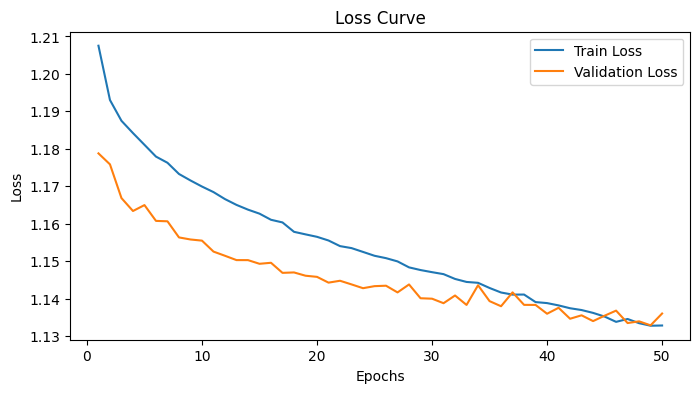

In [8]:
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

plot_loss(train_losses, val_losses)

**Evaluate Model**

In [9]:
def evaluate(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Convert class_names to strings
class_names = [str(name) for name in label_encoder.classes_]

# Evaluate on train set
y_train_true, y_train_pred = evaluate(model, train_loader)

# Evaluate on test set
y_test_true, y_test_pred = evaluate(model, test_loader)

# Print metrics
accuracy_train = accuracy_score(y_train_true, y_train_pred)
accuracy_test = accuracy_score(y_test_true, y_test_pred)
f1_test = f1_score(y_test_true, y_test_pred, average='weighted')

print(f'Training Accuracy: {accuracy_train:.3f}')
print(f'Test Accuracy: {accuracy_test:.3f}')
print(f'F1 Score: {f1_test:.3f}')
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=class_names, zero_division=0))

Training Accuracy: 0.613
Test Accuracy: 0.636
F1 Score: 0.503
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       212
           1       0.36      0.05      0.09       424
           2       0.00      0.00      0.00       437
           3       0.64      1.00      0.78      2715
           4       0.00      0.00      0.00       492

    accuracy                           0.64      4280
   macro avg       0.20      0.21      0.17      4280
weighted avg       0.44      0.64      0.50      4280

